In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models, Model
%matplotlib inline

from data_utils import get_column_input_dict

print(tf.version.VERSION)

2021-11-01 17:10:00.475786: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


2.3.4


In [2]:
train_df = pd.read_csv('./data/train_energy.csv')
print(f'train shape: {train_df.shape}')
eval_df = pd.read_csv('./data/validate_energy.csv')
print(f'eval shape: {eval_df.shape}')
test_df = pd.read_csv('./data/test_energy.csv')
print(f'test shape: {test_df.shape}')

train shape: (351802, 314)
eval shape: (117268, 314)
test shape: (117268, 314)


In [3]:
col_dict = get_column_input_dict(train_df)
col_dict.keys()

dict_keys(['CSV_COLUMNS', 'LABEL_COLUMNS', 'STRING_COLS', 'NUMERIC_COLS', 'DEFAULTS', 'EXCLUSION_COLS'])

### Column Labels for First Record in DataFrame

In [4]:
train_df[col_dict['LABEL_COLUMNS']].values[0]

array([7415.77136515, 6121.89789123, 5896.23751387, 5859.54495006,
       5859.51165372, 6977.95782464, 5682.83018868, 5734.572697  ,
       5767.20310766, 5786.35960044, 5939.54495006, 5967.48057714,
       7323.04106548, 5998.97891232, 5918.43507214, 6028.53496115,
       5790.86570477, 6565.92674806, 5506.31520533, 5590.63263041,
       5681.74250832, 5782.77469478, 6052.14206437, 6004.46170921,
       5742.91897891, 5510.72142064, 5141.30965594, 5393.09655938])

In [5]:
def df_to_dataset(dataframe, feature_columns, label_columns, shuffle=True, batch_size=32):
    
    dataframe = dataframe.copy()
    labels = dataframe[label_columns].values
    
    for col in dataframe.columns:
        if col not in feature_columns:
            dataframe.pop(col)
    
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    
    return ds

In [6]:
def create_input_layers(numeric_cols, string_cols):
    """Creates dictionary of input layers for each feature.

    Returns:
        Dictionary of `tf.Keras.layers.Input` layers for each feature.
    """
    inputs = {
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="float32")
        for colname in numeric_cols}

    inputs.update({
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="string")
        for colname in string_cols})

    return inputs

In [7]:
def categorical_fc(name, values):
    cat_column = fc.categorical_column_with_vocabulary_list(
            key=name, vocabulary_list=values)

    return fc.indicator_column(categorical_column=cat_column)


def create_feature_columns(train_df, numeric_cols, string_cols):
    feature_columns = {
        colname : fc.numeric_column(key=colname)
           for colname in numeric_cols
    }
    
    for col in string_cols:
        feature_columns[col] = categorical_fc(col, 
            train_df[col].unique())

    return feature_columns

In [30]:
def get_model_outputs(inputs):
    
    # # simple model
    # h1 = layers.Dense(28*4, activation="relu", name="h1")(inputs)
    # h2 = layers.Dense(28*3, activation="relu", name="h2")(h1)
    # hf = layers.Dense(28*2, activation="relu", name="h3")(h2)
    
    # medium model
    # h1 = layers.Dense(28*100, activation="relu", name="h1")(inputs)
    # h2 = layers.Dense(28*50, activation="relu", name="h2")(h1)
    # h3 = layers.Dense(28*25, activation="relu", name="h3")(h2)
    # h4 = layers.Dense(28*12, activation="relu", name="h4")(h3)
    # h5 = layers.Dense(28*4, activation="relu", name="h5")(h4)
    # hf = layers.Dense(28*2, activation="relu", name="h6")(h5)
    
    # # large model
    h1 = layers.Dense(28*200, activation="relu", name="h1")(inputs)
    h2 = layers.Dense(28*100, activation="relu", name="h2")(h1)
    h3 = layers.Dense(28*50, activation="relu", name="h3")(h2)
    h4 = layers.Dense(28*25, activation="relu", name="h4")(h3)
    h5 = layers.Dense(28*12, activation="relu", name="h5")(h4)
    h6 = layers.Dense(28*6, activation="relu", name="h6")(h5)
    h7 = layers.Dense(28*4, activation="relu", name="h7")(h6)
    hf = layers.Dense(28*2, activation="relu", name="h8")(h7)

    # Final output is a linear activation because this is regression
    output = layers.Dense(units=28, activation="linear", name="energy")(hf) 

    return output

In [9]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_pred - y_true) ** 2))

In [10]:
NUMERIC_COLS = col_dict['NUMERIC_COLS']
STRING_COLS = col_dict['STRING_COLS']

def build_dnn_model(LR):
    """Builds simple DNN using Keras Functional API.

    Returns:
        `tf.keras.models.Model` object.
    """
    # Create input layer
    inputs = create_input_layers(NUMERIC_COLS, STRING_COLS)

    # Create feature columns
    feature_columns = create_feature_columns(train_df, NUMERIC_COLS, STRING_COLS)

    # The constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires: LayerConstructor()(inputs)
    dnn_inputs = layers.DenseFeatures(
        feature_columns=feature_columns.values())(inputs)

    # Get output of model given inputs
    output = get_model_outputs(dnn_inputs)

    # Build model and compile it all together
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    
    opt = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(optimizer=opt, loss="mse", metrics=[rmse, "mse"])
    
    return model

# print("Here is our DNN architecture so far:\n")
# model = build_dnn_model(0.001)
# print(model.summary())

In [11]:
10000*5 // (64 * 1000)

0

In [ ]:
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset repeats, it'll wrap around

In [22]:
NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

109

In [15]:
eval_df.shape[0]

117268

In [ ]:
1000

In [16]:
NUM_EVAL_EXAMPLES // 1000

10

In [21]:
LR = 0.00001
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = train_df.shape[0]
#NUM_TRAIN_EXAMPLES = train_df.shape[0] * 1000  # training dataset repeats, it'll wrap around
NUM_EVALS = 50  # how many times to evaluate
# Enough to get a reasonable sample, but not so much that it slows down
NUM_EVAL_EXAMPLES = 10000

In [31]:
LR = 0.00001
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = train_df.shape[0]
#NUM_TRAIN_EXAMPLES = train_df.shape[0] * 1000  # training dataset repeats, it'll wrap around
NUM_EVALS = 50  # how many times to evaluate
# Enough to get a reasonable sample, but not so much that it slows down
NUM_EVAL_EXAMPLES = 10000

trainds = df_to_dataset(
    train_df,
    col_dict['STRING_COLS'] + col_dict['NUMERIC_COLS'],
    col_dict['LABEL_COLUMNS'],
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE).repeat()

evalds = df_to_dataset(
    eval_df,
    col_dict['STRING_COLS'] + col_dict['NUMERIC_COLS'],
    col_dict['LABEL_COLUMNS'],
    shuffle=False,
    batch_size=TEST_BATCH_SIZE).take(count=NUM_EVAL_EXAMPLES // 1000)

model = build_dnn_model(LR)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)
print(f'steps_per_epoch:{steps_per_epoch}')

logdir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
    #callbacks=[tensorboard_callback]
)

steps_per_epoch:109


2021-11-01 17:31:07.977094: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-01 17:31:07.977291: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


Epoch 1/50
109/109 [==============================] - 5s 49ms/step - loss: 19481083904.0000 - rmse: 98953.4844 - mse: 19481083904.0000 - val_loss: 16500368384.0000 - val_rmse: 123743.9219 - val_mse: 16500368384.0000
Epoch 2/50
109/109 [==============================] - 3s 31ms/step - loss: 11323826176.0000 - rmse: 71875.7266 - mse: 11323826176.0000 - val_loss: 11758614528.0000 - val_rmse: 104577.8125 - val_mse: 11758614528.0000
Epoch 3/50
109/109 [==============================] - 3s 31ms/step - loss: 6394044928.0000 - rmse: 55746.9414 - mse: 6394044928.0000 - val_loss: 10129799168.0000 - val_rmse: 97274.4062 - val_mse: 10129799168.0000
Epoch 4/50
109/109 [==============================] - 3s 31ms/step - loss: 9154048000.0000 - rmse: 68947.8438 - mse: 9154048000.0000 - val_loss: 8310846464.0000 - val_rmse: 87954.5312 - val_mse: 8310846464.0000
Epoch 5/50
109/109 [==============================] - 3s 32ms/step - loss: 7186360832.0000 - rmse: 59688.8047 - mse: 7186360832.0000 - val_loss:

### Large Model

Text(0.5, 0, 'Epoch')

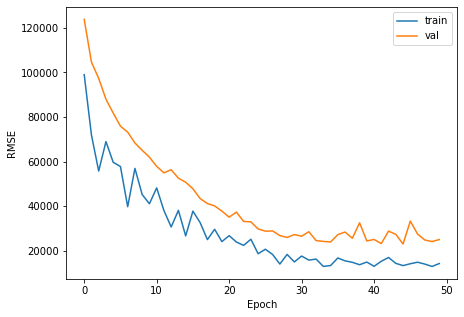

In [32]:
fig = plt.figure(figsize=(7, 5))
sns.lineplot(x=range(len(history.history['rmse'])), y=history.history['rmse'], label='train')
sns.lineplot(x=range(len(history.history['val_rmse'])), y=history.history['val_rmse'], label='val')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
#plt.title(f'Batch Size = {batch_size}, LR = {LR}, Model = {model_desc}')

In [37]:
model.save('dnn_baseline')

INFO:tensorflow:Assets written to: dnn_baseline/assets


In [38]:
%%bash
# gsutil ls gs://qwiklabs-gcp-00-f6858b4e5c0c/energy_forecasting/
gsutil cp -r dnn_baseline gs://qwiklabs-gcp-00-f6858b4e5c0c/energy_forecasting/dnn_baseline

Copying file://dnn_baseline/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://dnn_baseline/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://dnn_baseline/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [3 files][281.0 Mi

### Medium Model

Text(0.5, 0, 'Epoch')

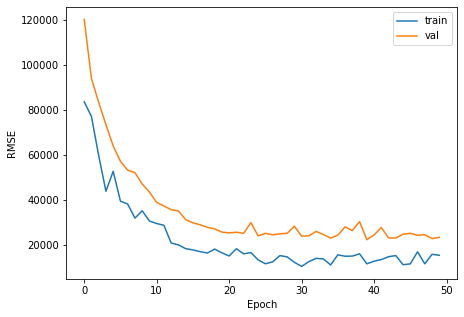

In [29]:
fig = plt.figure(figsize=(7, 5))
sns.lineplot(x=range(len(history.history['rmse'])), y=history.history['rmse'], label='train')
sns.lineplot(x=range(len(history.history['val_rmse'])), y=history.history['val_rmse'], label='val')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
#plt.title(f'Batch Size = {batch_size}, LR = {LR}, Model = {model_desc}')